In [101]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

%matplotlib inline

RFM Analysis
============
In this ipynb file, We aim to create columns below
- customer_unique_id: unique key
- recency: days since last purchase
- frequency: number of purchases
- monetary: total amount of purchases
- recency_cluster
- frequency_cluster
- monetary_cluster


In [102]:
## Use 4 necessary datasets
df_customers = pd.read_csv('datasets/olist_customers_dataset.csv')
# df_geolocation = pd.read_csv('datasets/olist_geolocation_dataset.csv')
df_order_items = pd.read_csv('datasets/olist_order_items_dataset.csv')
df_order_payments = pd.read_csv('datasets/olist_order_payments_dataset.csv')
# df_order_reviews = pd.read_csv('datasets/olist_order_reviews_dataset.csv')
df_orders = pd.read_csv('datasets/olist_orders_dataset.csv')
# df_products = pd.read_csv('datasets/olist_products_dataset.csv')
# df_sellers = pd.read_csv('datasets/olist_sellers_dataset.csv')
# df_product_category_name = pd.read_csv('datasets/product_category_name_translation.csv')

In [103]:
## Merge datasets
df1 = df_order_payments.merge(df_order_items, on='order_id')
df2 = df1.merge(df_orders, on='order_id')
df = df2.merge(df_customers, on='customer_id') ## Memo: 'customer_id is foreign key, not unique'

print(df.shape)
df.head()

(117601, 22)


,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,...,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,...,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22 00:00:00,708ab75d2a007f0564aedd11139c7708,39801,teofilo otoni,MG
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,...,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16 00:00:00,a8b9d3a27068454b1c98cc67d4e31e6f,2422,sao paulo,SP
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,...,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04 00:00:00,6f70c0b2f7552832ba46eb57b1c5651e,2652,sao paulo,SP
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,1,548e5bfe28edceab6b51fa707cc9556f,da8622b14eb17ae2831f4ac5b9dab84a,2017-12-12 12:13:20,89.90,...,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,2017-12-21 01:35:51,2018-01-04 00:00:00,87695ed086ebd36f20404c82d20fca87,36060,juiz de fora,MG
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,1,386486367c1f9d4f587a8864ccb6902b,cca3071e3e9bb7d12640c9fbe2301306,2018-05-31 16:14:41,113.57,...,delivered,2018-05-21 13:59:17,2018-05-21 16:14:41,2018-05-22 11:46:00,2018-06-01 21:44:53,2018-06-13 00:00:00,4291db0da71914754618cd789aebcd56,18570,conchas,SP


In [104]:
## datatypes for each column
df.dtypes

##some data objects should be converted to datetime

order_id                          object
payment_sequential                 int64
payment_type                      object
payment_installments               int64
payment_value                    float64
order_item_id                      int64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
dtype: object

In [105]:
## Convert data object to datetime
df_columns = [
  'shipping_limit_date',
  'order_purchase_timestamp',
  'order_approved_at',
  'order_delivered_carrier_date',
  'order_delivered_customer_date',
  'order_estimated_delivery_date'
]

for col in df_columns:
  df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

## Feature Engineering
Create new features from the original dataset

In [106]:
## order purchase year, month, day, hour
df['order_purchase_year'] = df['order_purchase_timestamp'].dt.year
df['order_purchase_month'] = df['order_purchase_timestamp'].dt.month
df['order_purchase_day'] = df['order_purchase_timestamp'].dt.day ## We can delete this column because we have day_of_week
df['order_purchase_hour'] = df['order_purchase_timestamp'].dt.hour

## order purchase dayofweek
df['order_purchase_day_of_week'] = df['order_purchase_timestamp'].dt.dayofweek. \
    map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'})

df['delivery_ahead_days'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days

## Todo: add more features


## Data Cleaning
- Check for missing values
- Our EDA shows that the first and last 2-3 months have less data. We will remove these months from the dataset.



In [107]:
## Data Cleaning task here

## Recency

In [108]:
## We use df_rfm for Recency, Frequency, Monetary
df_rfm = pd.DataFrame(df['customer_unique_id'])
df_rfm.columns = ['customer_unique_id']

## Get the latest purchase date for each customer
df_latest_purchase = df.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
df_latest_purchase.columns = ['customer_unique_id', 'latest_purchase_date']
## Get Recency
df_latest_purchase['recency'] = (
    df_latest_purchase['latest_purchase_date'].max() - df_latest_purchase['latest_purchase_date']
).dt.days

## Merge Recency to df_rfm
df_rfm = df_rfm.merge(df_latest_purchase, on='customer_unique_id')

df_rfm.head()

,customer_unique_id,latest_purchase_date,recency
0,708ab75d2a007f0564aedd11139c7708,2018-04-25 22:01:49,130
1,a8b9d3a27068454b1c98cc67d4e31e6f,2018-06-26 11:01:38,68
2,6f70c0b2f7552832ba46eb57b1c5651e,2017-12-12 11:19:55,264
3,87695ed086ebd36f20404c82d20fca87,2017-12-06 12:04:06,270
4,4291db0da71914754618cd789aebcd56,2018-08-01 08:29:38,33


/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_93886/2131498726.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recency["clusters"] = kmeans.labels_
/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders

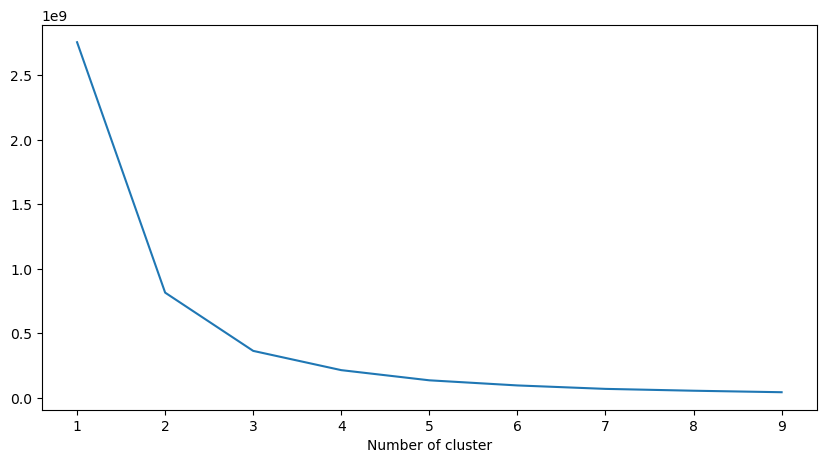

In [109]:
## Use k-means to get recency_cluster
## First of all, we need to know the optimal number of clusters
sse={}
df_recency = df_rfm[['recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [110]:
## The plot shows that the optimal number is 4 or 5. We choose 4
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_rfm[['recency']])
df_rfm['recency_cluster'] = kmeans.predict(df_rfm[['recency']])

## recency_cluster's number is not meaningful, we need to change it to meaningful number
def order_cluster(cluster_column_name, target_column_name,df):
    df_tmp = df.groupby(cluster_column_name)[target_column_name].mean().reset_index()
    df_tmp = df_tmp.sort_values(by=target_column_name, ascending=False).reset_index(drop=True)
    df_tmp['index'] = df_tmp.index

    df_output = pd.merge(
        df,
        df_tmp[[cluster_column_name,'index']],
        on=cluster_column_name
    )
    df_output = df_output.drop([cluster_column_name], axis=1)
    df_output = df_output.rename(columns = {"index": cluster_column_name})
    return df_output

df_rfm = order_cluster('recency_cluster', 'recency', df_rfm)

df_rfm.groupby('recency_cluster')['recency'].describe()

/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,20583.0,490.674634,59.104594,406.0,444.0,481.0,533.0,728.0
1,31047.0,320.158663,43.961357,255.0,281.0,313.0,357.0,405.0
2,33774.0,188.561231,34.931226,129.0,159.0,188.0,219.0,254.0
3,32197.0,67.290959,36.307775,0.0,33.0,67.0,102.0,128.0


<Axes: xlabel='recency', ylabel='recency_cluster'>

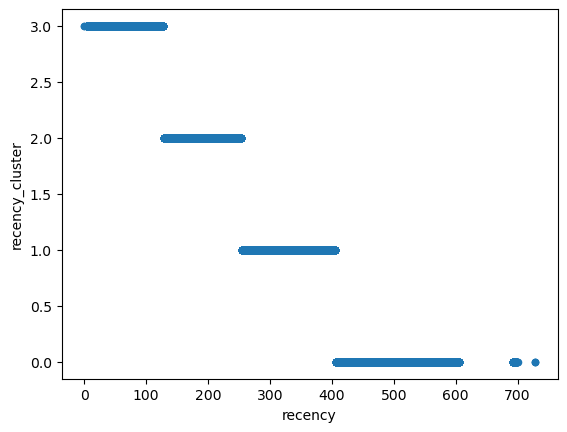

In [130]:
## The mean values show the recency_cluster is meaningful


## Frequency

In [112]:
df_frequency = df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
df_frequency.columns = ['customer_unique_id', 'frequency']

## Merge Frequency to df_rfm
df_rfm = df_rfm.merge(df_frequency, on='customer_unique_id')

df_rfm['frequency'].describe()

count    117601.000000
mean          1.083732
std           0.392386
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          16.000000
Name: frequency, dtype: float64

In [113]:
## The table above shows that most customers ordered only once.
## It might be better not to use frequency column.

## Monetary

In [114]:
df_monetary = df.groupby('customer_unique_id')['payment_value'].sum().reset_index()

df_rfm = df_rfm.merge(df_monetary, on='customer_unique_id')

df_monetary.describe()

,payment_value
count,95419.000000
mean,212.831142
std,641.763082
min,9.590000
25%,63.910000
50%,113.150000
75%,202.545000
max,109312.640000


/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_93886/1291469255.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_revenue["clusters"] = kmeans.labels_
/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders

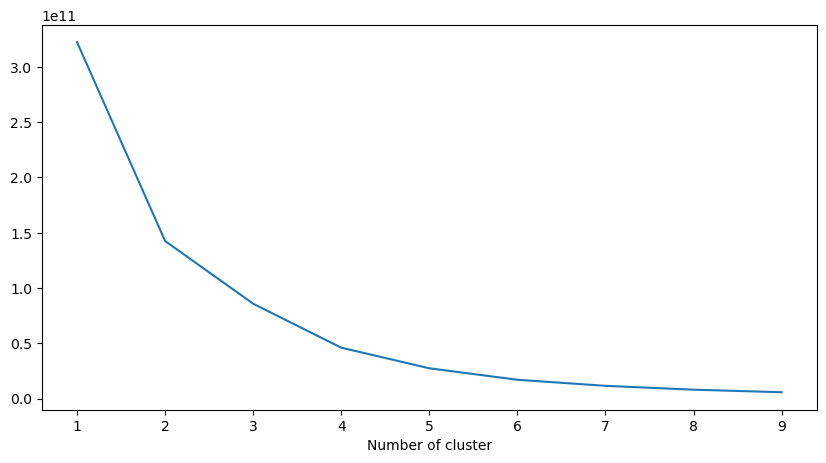

In [115]:
## Use k-means
sse={}
df_revenue = df_rfm[['payment_value']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue)
    df_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [116]:
## The plot shows that the optimal number is 4, 5, or 6. We choose 5.
kmeans = KMeans(n_clusters=6)
kmeans.fit(df_rfm[['payment_value']])
df_rfm['monetary_cluster'] = kmeans.predict(df_rfm[['payment_value']])


#order the cluster numbers
df_rfm = order_cluster('monetary_cluster', 'payment_value', df_rfm)

#show details of the dataframe
df_rfm.groupby('monetary_cluster')['payment_value'].describe()

/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,count,mean,std,min,25%,50%,75%,max
monetary_cluster,,,,,,,,
0,8.0,109312.640000,0.000000,109312.64,109312.640,109312.64,109312.64,109312.64
1,46.0,43587.292174,2837.177072,36489.24,44048.000,44048.00,45256.00,45256.00
2,184.0,20278.110435,5207.417793,14196.28,16313.600,19174.38,25051.89,30186.00
3,727.0,7237.122050,2182.588985,4595.04,5464.120,6702.72,8425.44,12834.50
4,5499.0,1943.702997,843.985012,1067.94,1301.005,1652.40,2289.69,4564.75
5,111137.0,194.974239,195.561569,9.59,67.720,124.80,235.69,1067.64


In [117]:
## Most cusotmers in the cluster 5.
## So I use log transformation, and recreate the clusters.

## Remove monetary_cluster column
df_rfm = df_rfm.drop('monetary_cluster', axis=1)

# Apply log transformation
df_rfm['monetary_log'] = np.log(df_rfm['payment_value'])

# Run K-means on the transformed data
kmeans = KMeans(n_clusters=6)
kmeans.fit(df_rfm[['monetary_log']])
df_rfm['monetary_cluster'] = kmeans.predict(df_rfm[['monetary_log']])

# Order the cluster numbers
df_rfm = order_cluster('monetary_cluster', 'monetary_log', df_rfm)

# Show details of the dataframe
df_rfm.groupby('monetary_cluster')['monetary_log'].describe()


/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,count,mean,std,min,25%,50%,75%,max
monetary_cluster,,,,,,,,
0,3015.0,8.312208,0.712272,7.564155,7.771978,8.099129,8.628684,11.601967
1,11073.0,6.812971,0.337939,6.331929,6.523342,6.752457,7.066851,7.563387
2,20362.0,5.845446,0.248416,5.456560,5.630746,5.818895,6.049374,6.331591
3,33160.0,5.063326,0.209584,4.715100,4.886715,5.057582,5.239204,5.456517
4,30974.0,4.368001,0.204034,3.999301,4.194793,4.363735,4.547329,4.715011
5,19017.0,3.635048,0.263419,2.260721,3.477541,3.676301,3.846738,3.999118


In [119]:
## It looks nice because the each cluster's count is similar, compoared to the previous one.
## Now, we have recency_cluster, and monetary_cluster. Let's get the overall RM Score.
df_rfm['overall_score'] = df_rfm['recency_cluster'] + df_rfm['monetary_cluster']

In [120]:
## Show the mean of recency and monetary_log for each overall_score
df_rfm.groupby('overall_score')[['recency', 'monetary_log']].mean()

,recency,monetary_log
overall_score,,
0,498.455189,8.180462
1,443.656789,7.300699
2,383.727802,6.535284
3,341.934853,5.886422
4,293.219075,5.330363
5,244.248448,4.825340
6,167.341176,4.497796
7,116.416927,4.073294
8,65.938344,3.628521


In [121]:
## Show the count of recency and monetary_log for each overall_score
df_rfm.groupby('overall_score')[['recency', 'monetary_log']].count()

,recency,monetary_log
overall_score,,
0,424,424
1,2666,2666
2,7219,7219
3,15442,15442
4,22910,22910
5,27225,27225
6,22865,22865
7,13741,13741
8,5109,5109


In [123]:
## Segment customers based on their overall_score
df_rfm['Segment'] = 'Low-Value'
df_rfm.loc[df_rfm['overall_score']>3,'Segment'] = 'Mid-Value'
df_rfm.loc[df_rfm['overall_score']>6,'Segment'] = 'High-Value'

df_rfm.head()

,customer_unique_id,latest_purchase_date,recency,recency_cluster,frequency,payment_value,monetary_log,monetary_cluster,overall_score,Segment
0,708ab75d2a007f0564aedd11139c7708,2018-04-25 22:01:49,130,2,1,99.33,4.598448,4,6,Mid-Value
1,bd5fb6a2e66d7bfb061efd93b994f168,2018-01-29 19:54:35,216,2,1,67.50,4.212128,4,6,Mid-Value
2,1504b719eb728716ff7583dc7b86a0b0,2018-04-19 09:55:30,136,2,1,64.03,4.159352,4,6,Mid-Value
3,47a0a92a1b4d507faa45c6d4910e9d2d,2018-02-26 09:55:52,188,2,1,68.49,4.226688,4,6,Mid-Value
4,f42a3583d172ef020244c94136cac8db,2018-02-01 07:44:28,214,2,1,90.05,4.500365,4,6,Mid-Value


Text(0, 0.5, 'monetary_log')

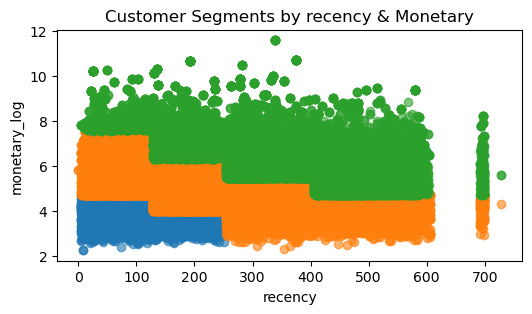

In [129]:
## plot the segments
fig, axs = plt.subplots(figsize=(6, 3), gridspec_kw={'wspace': 0.4})

for segment in ['High-Value', 'Mid-Value', 'Low-Value']:
  subset = df_rfm[df_rfm['Segment'] == segment]
  axs.scatter(subset['recency'], subset['monetary_log'], label=segment, alpha=0.6)
axs.set_title('Customer Segments by Recency & Monetary')
axs.set_xlabel('recency')
axs.set_ylabel('monetary_log')